In [1]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

In [2]:
import json
import pathlib
import typing as tp

import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import ImageClassifyDataset
# from model import NeuralNetwork


data_dir = pathlib.Path("/home/david/study/shad/cv_fall_2022/lesson_7_transfer_learning/public_tests/00_test_img_input")
output_dir = ""

train_dir = data_dir/'train'
test_dir = data_dir/'test'

train_gt: tp.Dict[str, np.ndarray] = read_csv(train_dir/'gt.csv')
train_img_dir = train_dir/'images'

test_img_dir = test_dir/'images'


# model = train_classifier(train_gt, train_img_dir, fast_train=False)

# model_filename = './facepoints_model.ckpt'
# test_img_dir = test_dir/'images'
# img_classes = classify(model_filename, test_img_dir)
# # save_csv(detected_points, join(output_dir, 'output.csv'))

In [11]:
ds = ImageClassifyDataset("train", 0.932, train_img_dir, train_gt, new_size=(128, 128))
len(ds)

2330

tensor([39.])

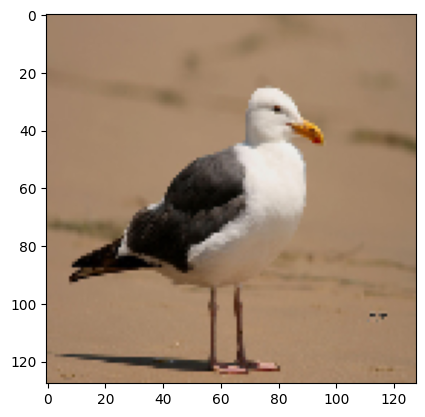

In [19]:
i = 10
plt.imshow(ds[i][0].numpy().transpose(1, 2, 0));
ds[i][1]